In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings("ignore")
import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [33]:
Z = pd.read_csv("./SMSSpamCollection.csv", sep=",")

In [34]:
Z.head(5)

,target,text
0,ham,Go until jurong point
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,Nah I don't think he goes to usf


In [35]:
y=Z['target'].replace({'spam':-1,'ham':1})
X=pd.DataFrame(Z['text'])
print(y.unique(),X)

[ 1 -1]                                                    text
0                                 Go until jurong point
1                         Ok lar... Joking wif u oni...
2     Free entry in 2 a wkly comp to win FA Cup fina...
3     U dun say so early hor... U c already then say...
4                      Nah I don't think he goes to usf
...                                                 ...
5547  This is the 2nd time we have tried 2 contact u...
5548               Will ü b going to esplanade fr home?
5549                                               Pity
5550  The guy did some bitching but I acted like i'd...
5551                         Rofl. Its true to its name

[5552 rows x 1 columns]


In [38]:
#nltk.download('punkt')
#nltk.download('stopwords')

In [39]:
stop = stopwords.words('english')
stemmer = nltk.stem.snowball.EnglishStemmer('english')
print (' '.join(stopwords.words('english')[:20]))

i me my myself we our ours ourselves you you're you've you'll you'd your yours yourself yourselves he him his


In [40]:
# Функция обработки текста 
def preprocess_text(texts):
    stop_words = set(stopwords.words('english'))
    regex = re.compile('[^a-z A-Z]')
    preprocess_texts = []
    for i in  tqdm.tqdm(range(len(texts))):
        text = str(texts[i])
        text = regex.sub(' ', text).lower()
        word_tokens = word_tokenize(text) 
        filtered_sentence = [w for w in word_tokens if not w in stop_words] 
        preprocess_texts.append( ' '.join(filtered_sentence))
    
    return preprocess_texts

In [41]:
def stemming_texts(texts):
    st = nltk.stem.snowball.EnglishStemmer('english')
    stem_text = []
    for text in tqdm.tqdm(texts):
        word_tokens = word_tokenize(text)
        stem_text.append(' '.join([st.stem(word) for word in word_tokens]))
    return stem_text

In [42]:
X['text'] = preprocess_text(X['text'])

100%|████████████████████████████████████████████████████████████████████████████| 5552/5552 [00:00<00:00, 9104.26it/s]


In [43]:
X['text'] = stemming_texts(X['text'])

100%|████████████████████████████████████████████████████████████████████████████| 5552/5552 [00:00<00:00, 5964.16it/s]


In [44]:
X.head()

,text
0,go jurong point
1,ok lar joke wif u oni
2,free entri wkli comp win fa cup final tkts st ...
3,u dun say earli hor u c alreadi say
4,nah think goe usf


In [45]:
X=X.text

In [46]:
tf_vectorizer = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2), min_df=0.001, norm=None)

In [47]:
Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.30, random_state=42)

In [48]:
Xtr_tfidf = tf_vectorizer.fit_transform(Xtr)
Xval_tfidf = tf_vectorizer.transform(Xval)

In [49]:
Xtr_tfidf.shape, Xval_tfidf.shape

((3886, 1630), (1666, 1630))

In [50]:
logit_sgd = SGDClassifier(
    loss='log', 
    shuffle=True, 
    n_iter_no_change=10, 
    max_iter=500, 
    penalty='l2', 
    random_state=42
)

In [51]:
logit_sgd.fit(Xtr_tfidf, ytr)
print("train accuracy=", accuracy_score(logit_sgd.predict(Xtr_tfidf), ytr))
print("validation accuracy=",accuracy_score(logit_sgd.predict(Xval_tfidf), yval))
print(classification_report(logit_sgd.predict(Xval_tfidf), yval))

train accuracy= 0.9951106536284097
validation accuracy= 0.9711884753901561
              precision    recall  f1-score   support

          -1       0.87      0.90      0.88       202
           1       0.99      0.98      0.98      1464

    accuracy                           0.97      1666
   macro avg       0.93      0.94      0.93      1666
weighted avg       0.97      0.97      0.97      1666



In [52]:
logit_cv = LogisticRegressionCV(Cs=10, n_jobs=-1)
logit_cv.fit(Xtr_tfidf, ytr)

LogisticRegressionCV(n_jobs=-1)

In [53]:
print("train accuracy=", accuracy_score(logit_cv.predict(Xtr_tfidf), ytr))
print("validation accuracy=", accuracy_score(logit_cv.predict(Xval_tfidf), yval))
print(classification_report(logit_cv.predict(Xval_tfidf), yval))

train accuracy= 0.9951106536284097
validation accuracy= 0.9765906362545018
              precision    recall  f1-score   support

          -1       0.84      0.97      0.90       183
           1       1.00      0.98      0.99      1483

    accuracy                           0.98      1666
   macro avg       0.92      0.97      0.94      1666
weighted avg       0.98      0.98      0.98      1666



In [54]:
def visualize_coefficients(coef, feature_names, title, plot_num, n_top_features=25):
    interesting_coefficients = np.argsort(coef)[-n_top_features:]
    plt.figure(figsize=(15, 15))
    plt.subplot(510+plot_num+1)
    colors = ["lightblue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + n_top_features), 
               feature_names[interesting_coefficients], rotation=60, ha="right", fontsize=14);
    plt.title(title)

In [55]:
logit_cv.coef_

array([[ 0.04179115,  0.02580301,  0.05077451, ...,  0.03213771,
         0.19430775, -0.03273729]])

In [56]:
tf_vectorizer.get_feature_names_out

<bound method CountVectorizer.get_feature_names_out of TfidfVectorizer(min_df=0.001, ngram_range=(1, 2), norm=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])>

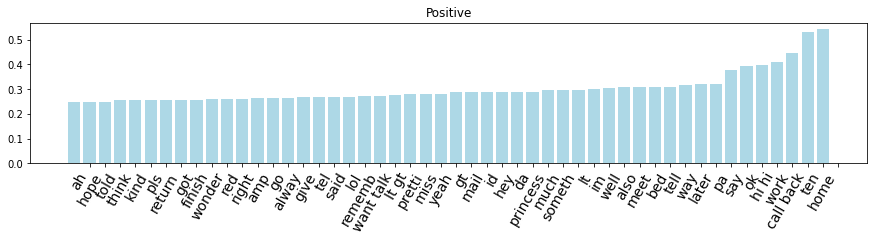

In [57]:
visualize_coefficients(logit_cv.coef_[0,:], tf_vectorizer.get_feature_names_out(),title="Positive", plot_num=0, n_top_features=50)

In [58]:
def visualize_coefficients_2(coef, feature_names, title, plot_num, n_top_features=50):
    interesting_coefficients = np.argsort(coef)[0:n_top_features]
    plt.figure(figsize=(15, 15))
    plt.subplot(510+plot_num+1)
    colors = ["lightblue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + n_top_features), 
               feature_names[interesting_coefficients], rotation=60, ha="right", fontsize=14);
    plt.title(title)

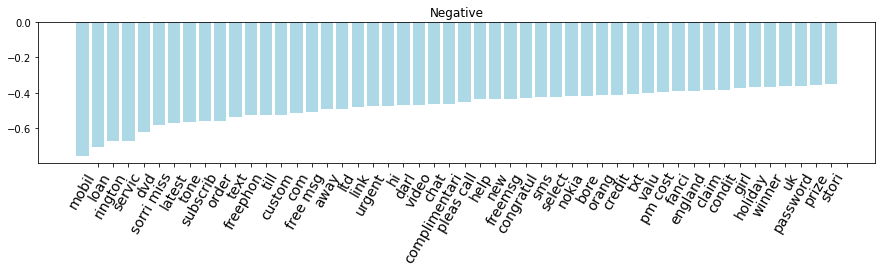

In [59]:
visualize_coefficients_2(logit_cv.coef_[0,:], tf_vectorizer.get_feature_names_out(),title="Negative", plot_num=1, n_top_features=50)